In [2]:
!pip install opencv-python

In [3]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

print("complete")

complete


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
!tar -xf images.tar -C ~/work/class_activation_map/
!tar -xf annotation.tar -C ~/work/class_activation_map/
!tar -xf lists.tar -C ~/work/class_activation_map/

print("데이터 다운로드 완료!")

--2025-11-19 02:28:41--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.1’

images.tar.1         24%[===>                ] 188.80M  10.7MB/s    eta 62s    ^C
^C
171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... ^C
^C
데이터 다운로드 완료!


In [5]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Images')   # 이미지들이 위치한 폴더
mat_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map')   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [6]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation')

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


In [8]:
def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


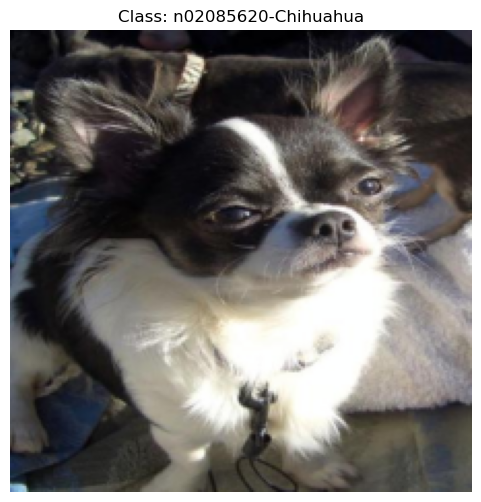

In [10]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
train_sample = train_dataset[16]

visualize(train_sample)

Label index: 2
Class name: n02085936-Maltese_dog


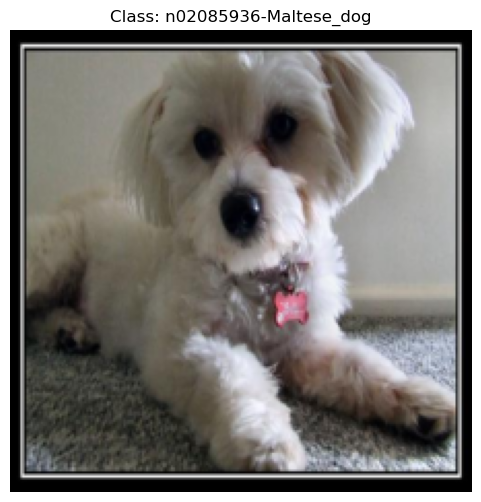

In [11]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
test_sample = valid_dataset[156]

visualize(test_sample)

In [12]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation/n02099601-golden_retriever/n02099601_7930')


# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02099601
filename: n02099601_7930
source: 
		
database: ImageNet database
size: 
		
width: 500
height: 375
depth: 3
segment: 0
object: 
		
name: golden_retriever
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 251
ymin: 20
xmax: 388
ymax: 370


In [13]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\nEpoch {epoch+1}/{num_epochs} 시작")
        for batch_idx, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            if (batch_idx + 1) % 50 == 0:
                print(f"  Step {batch_idx+1} - Loss: {loss.item():.4f}")

        train_loss = running_loss / (batch_idx + 1)
        train_acc = correct / total
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # 검증 단계
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_loss = running_loss / len(valid_loader)
        test_acc = correct / total
        print(f"Validation - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

In [18]:
%%time

train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5 시작
  Step 50 - Loss: 4.4928
  Step 100 - Loss: 4.3355
  Step 150 - Loss: 2.9060
  Step 200 - Loss: 3.2657
  Step 250 - Loss: 2.8836
  Step 300 - Loss: 1.8943
  Step 350 - Loss: 2.2731
  Step 400 - Loss: 1.7917
  Step 450 - Loss: 1.7464
  Step 500 - Loss: 2.0345
  Step 550 - Loss: 1.6986
  Step 600 - Loss: 0.9230
  Step 650 - Loss: 1.2480
  Step 700 - Loss: 1.0762
  Step 750 - Loss: 1.0468
  Step 800 - Loss: 1.5599
  Step 850 - Loss: 1.2948
  Step 900 - Loss: 1.0365
  Step 950 - Loss: 0.8240
  Step 1000 - Loss: 1.6952
Train - Loss: 2.1184, Accuracy: 53.51%
Validation - Loss: 0.7477, Accuracy: 77.87%

Epoch 2/5 시작
  Step 50 - Loss: 0.6827
  Step 100 - Loss: 0.5732
  Step 150 - Loss: 0.5824
  Step 200 - Loss: 0.6878
  Step 250 - Loss: 0.3406
  Step 300 - Loss: 0.9123
  Step 350 - Loss: 0.6374
  Step 400 - Loss: 0.6979
  Step 450 - Loss: 1.3552
  Step 500 - Loss: 0.9889
  Step 550 - Loss: 0.7829
  Step 600 - Loss: 0.9047
  Step 650 - Loss: 1.4305
  Step 700 - Loss: 0.2779
  Step

In [19]:
# Q. '/work/class_activation_map' 에 'cam_model1.h5'을 저장하세요.

cam_model_path = os.path.join(os.getenv("HOME"), "work/class_activation_map/cam_model.pt")

torch.save(model, cam_model_path)

#CAM

In [20]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [21]:
# 원하는 데이터를 골라서 진행해보세요

image, label, bbox = train_dataset[606]
sample_image = image.unsqueeze(0).to(device)

In [22]:
# 모델을 불러오세요

# [[YOUR CODE]]
model = torch.load(cam_model_path, weights_only=False)

In [23]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [24]:
cam = generate_cam(model, sample_image)

In [25]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

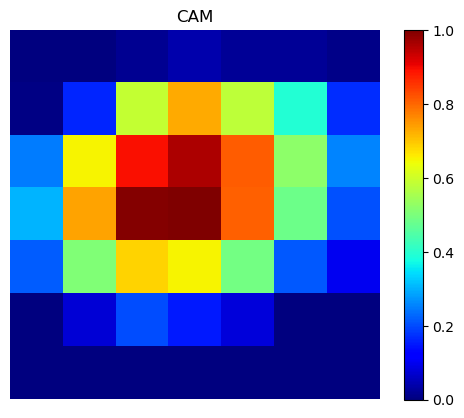

In [26]:
visualize_cam(cam)

In [27]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

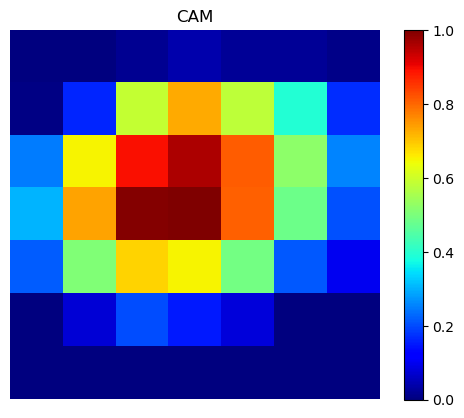

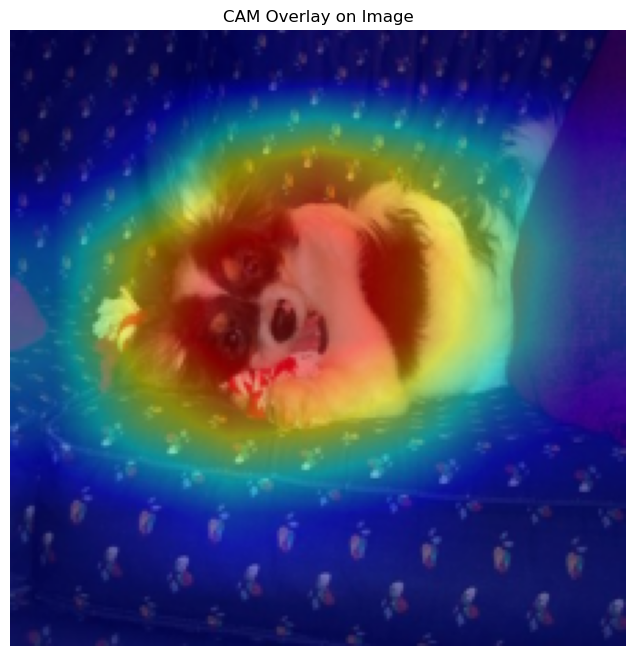

In [28]:
# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam, orig_img)

#Grad-CAM

In [29]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


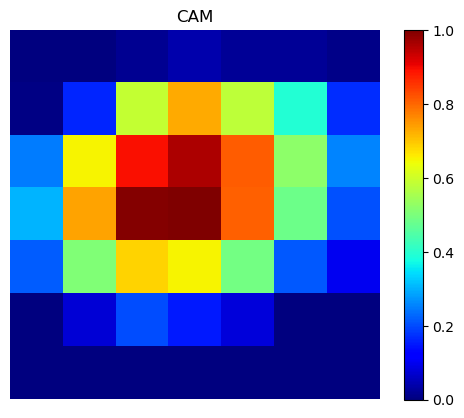

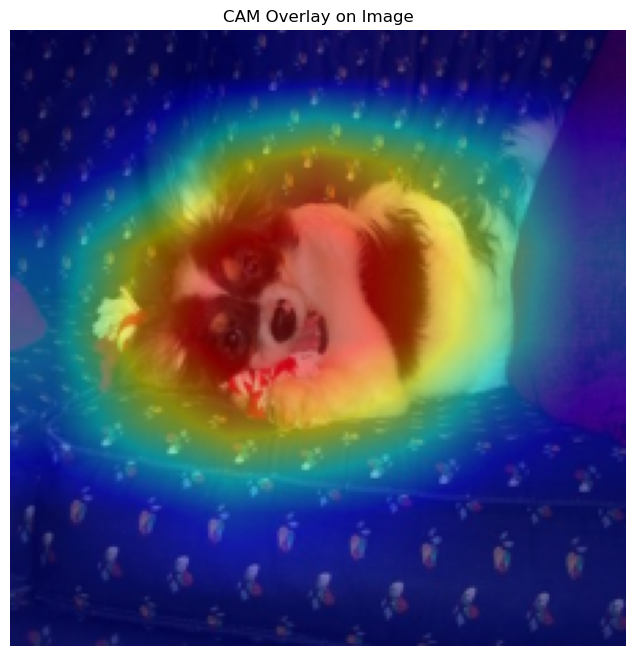

In [30]:
# layer4 사용
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

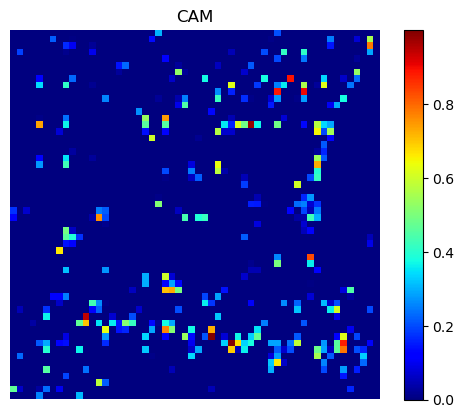

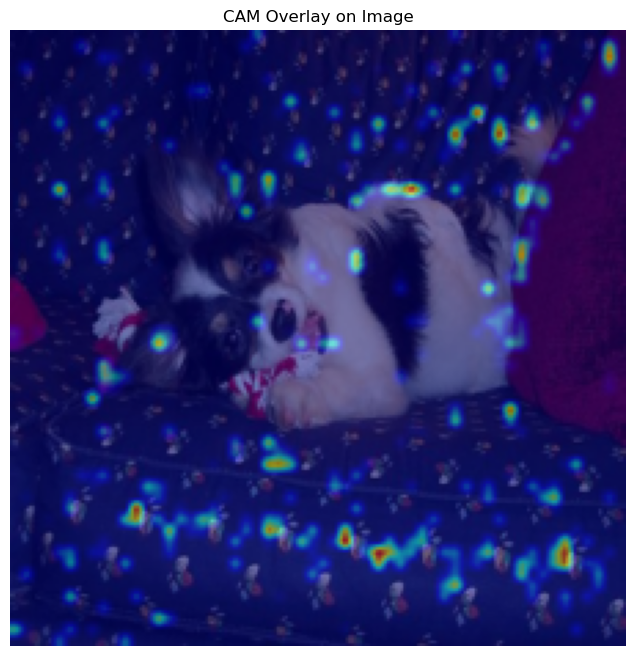

In [31]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer1")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

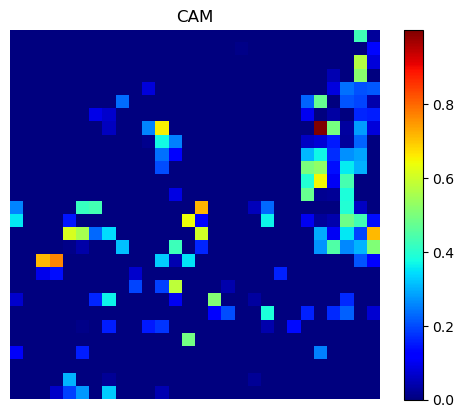

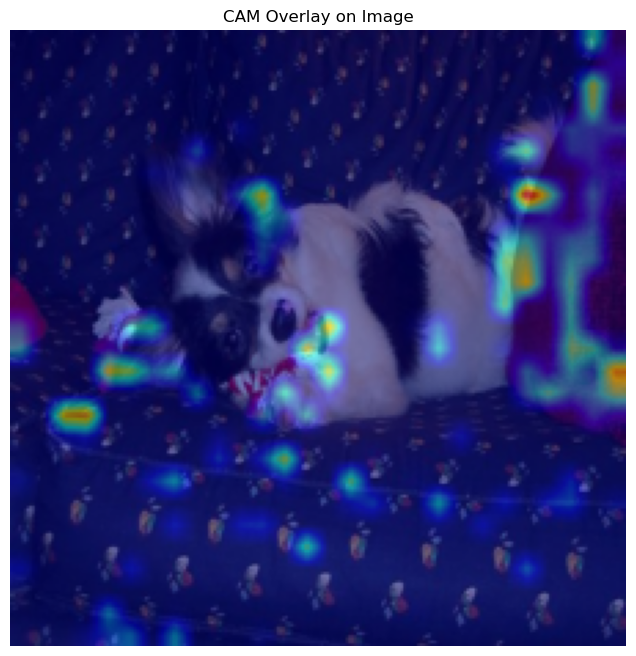

In [32]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer2")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

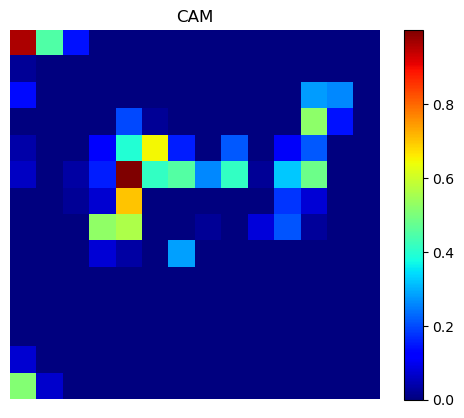

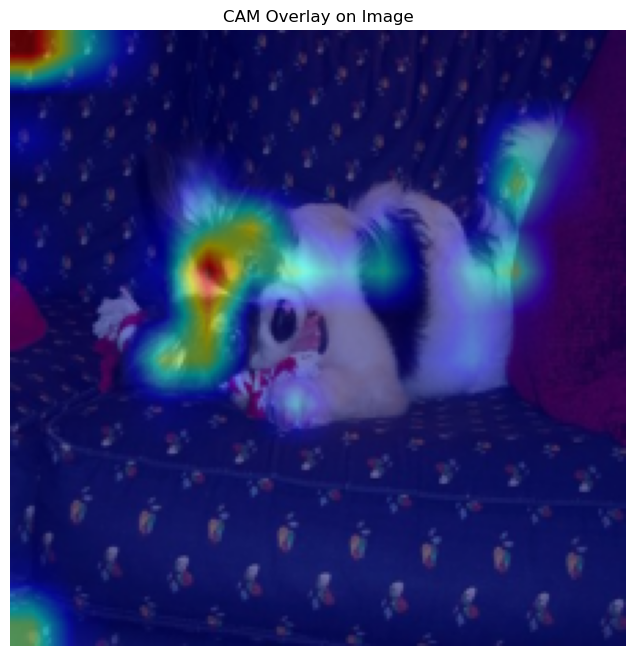

In [33]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer3")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

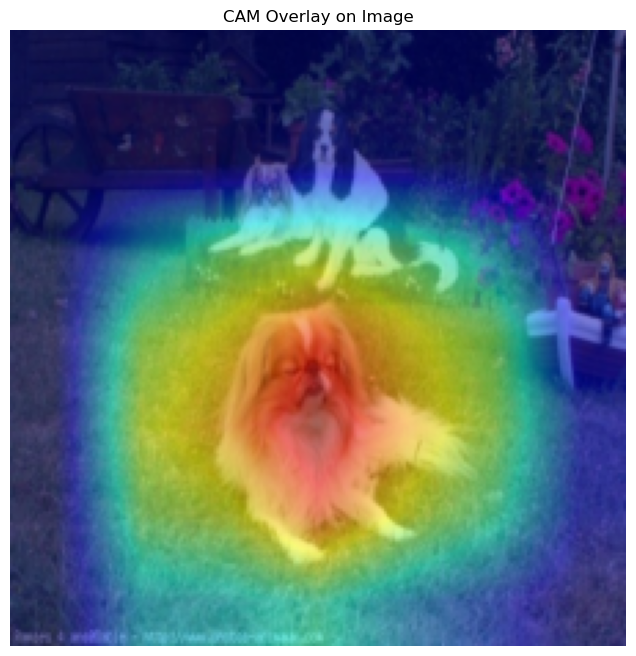

In [34]:
image, label, ground_bbox = train_dataset[150]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

visualize_cam_on_image(grad_cam, orig_img)

In [35]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [36]:
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
bbox = get_bbox(cam_resized, threshold=0.5)

print(bbox)

(np.int64(31), np.int64(37), np.int64(178), np.int64(155))


In [37]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

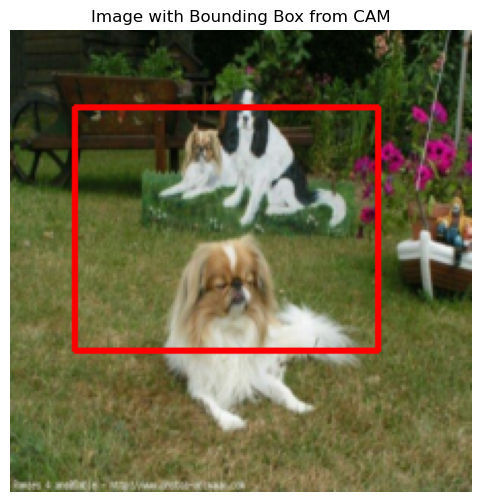

In [38]:
img_bbox = visualize_bbox_on_image(orig_img, bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

In [39]:
ground_bbox

[73.54666666666667, 98.0, 168.0, 194.5]

In [40]:
def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [41]:
get_iou(bbox, ground_bbox)

np.float64(0.25543786311463795)

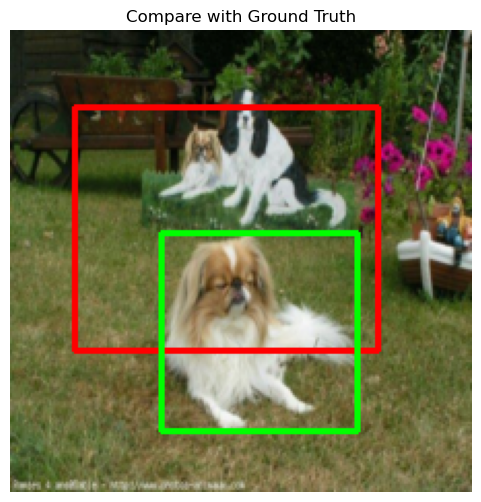

In [42]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

img_bbox = visualize_both_bbox_on_image(orig_img, bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Compare with Ground Truth")
plt.axis("off")
plt.show()